# Bike-count interpolation: Euclidean GP vs Graph GP (single-hour snapshot)

This notebook implements two comparable spatial interpolation analyses on the same single-hour snapshot:

1. Euclidean GP (baseline): Matérn/RBF kernel on 2D projected coordinates.
2. Graph GP (paper-style): graph Matérn kernel built from the graph Laplacian eigenpairs.

Both models:
- use the same snapshot time,
- use the same train/test split over sensor nodes,
- predict the same target (bike counts),
- are evaluated with the same metrics and plots.

Important: This is not a temporal model. We intentionally freeze time to one hour.



In [1]:
print("kernel alive")

kernel alive


In [2]:
# Core imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import osmnx as ox
import networkx as nx

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import scipy.linalg as la
from scipy.optimize import minimize

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Your project loader (as in your existing notebook)
from src.data.dataload import load_csv_folder_to_dataframe



## 1) Load & preprocess bike counter data

Assumptions (match your existing notebook):
- Raw CSVs live in `DATA_DIR`
- Columns include:
  - `domain_name` (e.g., 'Stadt Tübingen')
  - `counter_site` (counter ID)
  - `iso_timestamp` (timestamp)
  - `channels_all` (bike count)
  - `latitude`, `longitude` (counter location)



In [3]:
from pathlib import Path

DATA_DIR = "data/raw"   # adjust if needed
DOMAIN = "Stadt Ludwigsburg"

SNAPSHOT_TS = pd.Timestamp('2024-10-31 16:00:00+00:00')  # must exist after flooring to hour

df_all_path = Path("df_all.csv")

if df_all_path.exists():
    print("Loading cached dataframe from df_all.csv")
    df_loaded = pd.read_csv(df_all_path)
else:
    print("df_all.csv not found, loading raw CSV folder")
    df_loaded = load_csv_folder_to_dataframe(DATA_DIR)
    df_loaded.to_csv(df_all_path, index=False)


df_city = df_loaded[df_loaded["domain_name"] == DOMAIN].copy()
df_city["iso_timestamp"] = pd.to_datetime(df_city["iso_timestamp"], errors="coerce")
df_city = df_city.dropna(subset=["iso_timestamp"])

df_city_small = df_city[["counter_site", "iso_timestamp", "channels_all", "latitude", "longitude"]].copy()

# Freeze time to one hour:
df_city_small["ts_hour"] = df_city_small["iso_timestamp"].dt.floor("H")
df_snapshot = df_city_small[df_city_small["ts_hour"] == SNAPSHOT_TS].copy()

if df_snapshot.empty:
    raise ValueError(
        f"No rows found for SNAPSHOT_TS={SNAPSHOT_TS}. "
        "Pick a timestamp that exists in the data (after flooring to hour)."
    )

# Aggregate within the hour per counter (in case multiple rows exist)
df_obs = (
    df_snapshot
    .groupby("counter_site", as_index=False)
    .agg(
        y=("channels_all", "mean"),
        lat=("latitude", "first"),
        lon=("longitude", "first"),
    )
)

display(df_obs.head())
print("Observed counters in this snapshot:", len(df_obs))



Loading cached dataframe from df_all.csv


/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_9433/2552578026.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_city_small["ts_hour"] = df_city_small["iso_timestamp"].dt.floor("H")


,counter_site,y,lat,lon
0,Aldinger Straße,24.0,48.883139,9.210566
1,Alleenstraße,150.0,48.893189,9.192943
2,Bismarckstraße,60.0,48.899039,9.181309
3,Bottwartalstraße,58.0,48.903483,9.198207
4,Friedrich-Ebert-Straße,141.0,48.893033,9.206430


Observed counters in this snapshot: 15


In [4]:
# REMOVE this later: Selecting available timestamps

# Ensure timestamps are parsed
df_loaded["iso_timestamp"] = pd.to_datetime(df_loaded["iso_timestamp"], errors="coerce")

# Floor to hour exactly as in the pipeline
df_loaded["ts_hour"] = df_loaded["iso_timestamp"].dt.floor("H")

# Restrict to your domain
df_city = df_loaded[df_loaded["domain_name"] == DOMAIN]

# List unique hours, sorted
unique_hours = (
    df_city["ts_hour"]
    .dropna()
    .sort_values()
    .unique()
)

print("Number of unique hourly snapshots:", len(unique_hours))
print("First 10:", unique_hours[:10])
print("Last 10:", unique_hours[-10:])


/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_9433/1601258778.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_loaded["ts_hour"] = df_loaded["iso_timestamp"].dt.floor("H")


Number of unique hourly snapshots: 70852
First 10: <DatetimeArray>
['2017-09-26 22:00:00+00:00', '2017-09-27 06:00:00+00:00',
 '2017-09-27 07:00:00+00:00', '2017-09-27 08:00:00+00:00',
 '2017-09-27 09:00:00+00:00', '2017-09-27 10:00:00+00:00',
 '2017-09-27 11:00:00+00:00', '2017-09-27 12:00:00+00:00',
 '2017-09-27 13:00:00+00:00', '2017-09-27 14:00:00+00:00']
Length: 10, dtype: datetime64[ns, UTC]
Last 10: <DatetimeArray>
['2025-10-31 12:00:00+00:00', '2025-10-31 13:00:00+00:00',
 '2025-10-31 14:00:00+00:00', '2025-10-31 15:00:00+00:00',
 '2025-10-31 16:00:00+00:00', '2025-10-31 17:00:00+00:00',
 '2025-10-31 18:00:00+00:00', '2025-10-31 19:00:00+00:00',
 '2025-10-31 20:00:00+00:00', '2025-10-31 21:00:00+00:00']
Length: 10, dtype: datetime64[ns, UTC]


## 2) Build the road/bike graph and map counters to nearest graph nodes

We:
1. Build an OSMnx bike graph within a radius.
2. Map each counter coordinate to the nearest graph node.
3. Project the graph to a metric CRS for Euclidean-distance kernels.



In [5]:
from osmnx import simplify_graph

GRAPH_RADIUS_M = 2000  # adjust to cover all counters you care about

center = (df_obs["lat"].mean(), df_obs["lon"].mean())

# Build graph in lat/lon
G_ll = ox.graph_from_point(center, dist=GRAPH_RADIUS_M, network_type="bike")

# Keep the largest strongly connected component (helps with graph kernels/distances)
largest_scc = max(nx.strongly_connected_components(G_ll), key=len)
G_ll = G_ll.subgraph(largest_scc).copy()

# Map each counter to nearest node in the lat/lon graph
df_obs["node_id"] = df_obs.apply(
    lambda r: ox.distance.nearest_nodes(G_ll, X=r["lon"], Y=r["lat"]),
    axis=1
)

# Drop counters that map outside the graph (rare, but can happen near boundary)
df_obs = df_obs[df_obs["node_id"].isin(G_ll.nodes)].copy()
print("Counters kept after node mapping:", len(df_obs))

# Project graph to metric CRS (UTM). Node IDs remain the same.
G = ox.project_graph(G_ll)
print("Projected CRS:", G.graph.get("crs"))

# protect train & test nodes BEFORE simplification
protect_nodes = set(df_obs["node_id"])

# Projected node coordinates (meters)
node_xy = pd.DataFrame(
    {
        "node_id": list(G.nodes()),
        "x": [G.nodes[n]["x"] for n in G.nodes()],
        "y": [G.nodes[n]["y"] for n in G.nodes()],
    }
)

df_obs = df_obs.merge(node_xy, on="node_id", how="left")
display(df_obs.head())

# check how many nodes the graph has
print("Number of nodes in the graph:", len(G.nodes()))



Counters kept after node mapping: 15
Projected CRS: EPSG:32632


,counter_site,y_x,lat,lon,node_id,x,y_y
0,Aldinger Straße,24.0,48.883139,9.210566,272590518,515429.354398,5.414494e+06
1,Alleenstraße,150.0,48.893189,9.192943,9512032494,514139.679042,5.415629e+06
2,Bismarckstraße,60.0,48.899039,9.181309,271705119,513280.230178,5.416274e+06
3,Bottwartalstraße,58.0,48.903483,9.198207,135036403,514528.961602,5.416742e+06
4,Friedrich-Ebert-Straße,141.0,48.893033,9.206430,5165758557,515158.304360,5.415573e+06


Number of nodes in the graph: 3737


## 3) One fixed train/test split over observed counters

This split is reused for both models to ensure a fair comparison.



In [6]:
RANDOM_SEED = 43
N_TRAIN = 13  # paper uses 250; we have fewer counters

rng = np.random.default_rng(RANDOM_SEED)

n_obs = len(df_obs)
if n_obs < 4:
    raise ValueError(f"Need at least 4 observed counters for a meaningful split, got {n_obs}.")

n_train = min(N_TRAIN, n_obs - 1)  # keep at least 1 test point
train_rows = rng.choice(n_obs, size=n_train, replace=False)
is_train = np.zeros(n_obs, dtype=bool)
is_train[train_rows] = True

train_df = df_obs.iloc[is_train].copy()
test_df  = df_obs.iloc[~is_train].copy()

print(f"Train counters: {len(train_df)} | Test counters: {len(test_df)}")

print(df_obs.columns)
display(df_obs.head())

y_train = train_df["y_x"].to_numpy(dtype=float)  # bike counts
y_test  = test_df["y_x"].to_numpy(dtype=float)





Train counters: 13 | Test counters: 2
Index(['counter_site', 'y_x', 'lat', 'lon', 'node_id', 'x', 'y_y'], dtype='object')


,counter_site,y_x,lat,lon,node_id,x,y_y
0,Aldinger Straße,24.0,48.883139,9.210566,272590518,515429.354398,5.414494e+06
1,Alleenstraße,150.0,48.893189,9.192943,9512032494,514139.679042,5.415629e+06
2,Bismarckstraße,60.0,48.899039,9.181309,271705119,513280.230178,5.416274e+06
3,Bottwartalstraße,58.0,48.903483,9.198207,135036403,514528.961602,5.416742e+06
4,Friedrich-Ebert-Straße,141.0,48.893033,9.206430,5165758557,515158.304360,5.415573e+06


In [7]:
display(df_obs)

,counter_site,y_x,lat,lon,node_id,x,y_y
0,Aldinger Straße,24.0,48.883139,9.210566,272590518,515429.354398,5.414494e+06
1,Alleenstraße,150.0,48.893189,9.192943,9512032494,514139.679042,5.415629e+06
2,Bismarckstraße,60.0,48.899039,9.181309,271705119,513280.230178,5.416274e+06
3,Bottwartalstraße,58.0,48.903483,9.198207,135036403,514528.961602,5.416742e+06
4,Friedrich-Ebert-Straße,141.0,48.893033,9.206430,5165758557,515158.304360,5.415573e+06
5,Fuchshof,62.0,48.890275,9.219911,269466187,516189.086309,5.415291e+06
6,Kesseläcker (Verl. Nussackerweg),18.0,48.901772,9.171905,277767167,512599.071543,5.416559e+06
7,Königinallee,34.0,48.884836,9.206656,9006691822,515170.192129,5.414693e+06
8,Marbacher Straße - Favoritepark,99.0,48.902492,9.195814,9087901877,514351.113718,5.416638e+06
9,Marbacher Straße - Neckarbrücke,21.0,48.907326,9.219096,2070675484,516046.407403,5.417173e+06


## 4) Model A: Euclidean GP on projected coordinates

Input:
- X = (x, y) projected meters

Target:
- y = bike count at the chosen snapshot hour



In [8]:
print("train_df columns:", list(train_df.columns))
print("df_obs columns:", list(df_obs.columns))
print("node_xy columns:", list(node_xy.columns))


train_df columns: ['counter_site', 'y_x', 'lat', 'lon', 'node_id', 'x', 'y_y']
df_obs columns: ['counter_site', 'y_x', 'lat', 'lon', 'node_id', 'x', 'y_y']
node_xy columns: ['node_id', 'x', 'y']


In [9]:
X_train_euc = train_df[["x", "y_y"]].to_numpy(dtype=float)
X_test_euc  = test_df[["x", "y_y"]].to_numpy(dtype=float)

# Kernel: Constant * Matérn + White noise
kernel_euc = (
    ConstantKernel(1.0, (1e-3, 1e3)) *
    Matern(length_scale=200.0, nu=1.5) +
    WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e3))
)

gp_euc = GaussianProcessRegressor(
    kernel=kernel_euc,
    alpha=0.0,
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=RANDOM_SEED
)

gp_euc.fit(X_train_euc, y_train)

pred_mean_euc, pred_std_euc = gp_euc.predict(X_test_euc, return_std=True)

rmse_euc = np.sqrt(mean_squared_error(y_test, pred_mean_euc))
mae_euc  = mean_absolute_error(y_test, pred_mean_euc)


print("Euclidean GP kernel after fit:")
print(gp_euc.kernel_)
print(f"Euclidean GP  RMSE={rmse_euc:.3f}  MAE={mae_euc:.3f}")



Euclidean GP kernel after fit:
0.868**2 * Matern(length_scale=469, nu=1.5) + WhiteKernel(noise_level=0.294)
Euclidean GP  RMSE=28.050  MAE=26.656


## 5) Model B: Graph GP (graph Matérn) on the network

We build a weighted adjacency W:
- edge weight = inverse edge length (paper-style)

Then the normalized Laplacian:
- $L_{sym} = I - D^{-1/2} W D^{-1/2}$

We approximate the graph kernel with the smallest RANK eigenpairs of L_sym.

Graph Matérn spectral filter:
- phi(lambda) = (a + lambda)^(-nu), with a = 2*nu / kappa^2

We optimize hyperparameters by maximizing the GP marginal likelihood:
- kappa (length scale on the graph)
- sigma^2 (variance)
- varsigma^2 (noise variance)

We keep nu fixed (you can change it).



In [10]:
# ----- Build node indexing -----
nodes = list(G.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes)}
n_nodes = len(nodes)

# ----- Weighted adjacency W -----
rows, cols, data = [], [], []
for u, v, attr in G.edges(data=True):
    length = attr.get("length", None)
    if length is None or length <= 0:
        continue
    w = 1.0 / float(length)
    iu, iv = node_to_idx[u], node_to_idx[v]
    rows += [iu, iv]
    cols += [iv, iu]
    data += [w, w]

W = sp.coo_matrix((data, (rows, cols)), shape=(n_nodes, n_nodes)).tocsr()
deg = np.asarray(W.sum(axis=1)).ravel()
D_inv_sqrt = sp.diags(np.where(deg > 0, 1.0 / np.sqrt(deg), 0.0))

L_sym = sp.eye(n_nodes, format="csr") - D_inv_sqrt @ W @ D_inv_sqrt

# ----- Eigenpairs -----
RANK = min(100, n_nodes - 2)
evals, evecs = eigsh(L_sym, k=RANK, which="SM")
evals = np.maximum(evals, 0.0)

print("Eigenpairs computed:", evecs.shape)



Eigenpairs computed: (3737, 100)


In [11]:
use_bounds = False  # set to False to disable bounds in optimization

# Indices for training/test nodes
train_node_idx = np.array([node_to_idx[n] for n in train_df["node_id"]], dtype=int)
test_node_idx  = np.array([node_to_idx[n] for n in test_df["node_id"]], dtype=int)

nu_fixed = 1.5  # smoothness parameter nu

def build_Z(tau: float, sigma2: float) -> np.ndarray:
    """
    Diffusion kernel feature matrix:
      phi(lambda) = exp(-tau * lambda)
      K ≈ Z Z^T with Z = sqrt(sigma2) * U * sqrt(phi(lambda))
    """
    phi = np.exp(-tau * evals)
    Z = (evecs * np.sqrt(phi)[None, :]) * np.sqrt(sigma2)
    return Z


def neg_log_marginal_likelihood(params_log: np.ndarray) -> float:
    # params_log = [log_kappa, log_sigma2, log_noise_std]
    log_kappa, log_sigma2, log_noise = params_log
    kappa = np.exp(log_kappa)
    sigma2 = np.exp(log_sigma2)
    noise = np.exp(log_noise)

    Z = build_Z(kappa, sigma2)
    Ztr = Z[train_node_idx, :]

    K = Ztr @ Ztr.T
    K[np.diag_indices_from(K)] += noise**2 + 1e-8

    try:
        L = la.cholesky(K, lower=True, check_finite=False)
    except la.LinAlgError:
        return np.inf

    alpha = la.cho_solve((L, True), y_train, check_finite=False)

    n = len(y_train)
    nll = 0.5 * (y_train @ alpha) + np.sum(np.log(np.diag(L))) + 0.5 * n * np.log(2*np.pi)
    return float(nll)

x0 = np.log([0.03, 1.0, 0.1])  # kappa, sigma2, noise_std

if use_bounds:
    bounds = [
    (np.log(1e-2), np.log(0.5)),   # kappa
    (np.log(1e-3), np.log(10.0)),  # sigma2
    (np.log(1e-4), np.log(0.2)),   # noise
    ]
    res = minimize(
    neg_log_marginal_likelihood,
    x0=x0,
    bounds=bounds,
    method="L-BFGS-B",
    options={"maxiter": 500},
)
else:
    res = minimize(neg_log_marginal_likelihood, x0=x0, method="L-BFGS-B", options={"maxiter": 500})

print("Optimization success:", res.success, "|", res.message)
kappa_hat, sigma2_hat, noise_hat = np.exp(res.x)
kappa_hat = .01
noise_hat = .1
print(f"Fitted graph GP params: kappa={kappa_hat:.4g}, sigma2={sigma2_hat:.4g}, noise_std={noise_hat:.4g}")



Optimization success: True | CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Fitted graph GP params: kappa=0.01, sigma2=0.7285, noise_std=0.1


In [12]:
# Predict on test nodes
Z = build_Z(kappa_hat, sigma2_hat)
Ztr = Z[train_node_idx, :]
Zte = Z[test_node_idx, :]

Ktr = Ztr @ Ztr.T
Ktr[np.diag_indices_from(Ktr)] += noise_hat**2 + 1e-8

L = la.cholesky(Ktr, lower=True, check_finite=False)
alpha = la.cho_solve((L, True), y_train, check_finite=False)

Kte_tr = Zte @ Ztr.T
pred_mean_graph = Kte_tr @ alpha

# Predictive variance (latent)
Kte_diag = np.sum(Zte**2, axis=1)
v = la.solve_triangular(L, Kte_tr.T, lower=True, check_finite=False)
pred_var_graph = np.maximum(0.0, Kte_diag - np.sum(v*v, axis=0))
pred_std_graph = np.sqrt(pred_var_graph)

rmse_graph = np.sqrt(mean_squared_error(y_test, pred_mean_graph))
mae_graph  = mean_absolute_error(y_test, pred_mean_graph)

print(f"Graph GP      RMSE={rmse_graph:.3f}  MAE={mae_graph:.3f}")



Graph GP      RMSE=36.179  MAE=35.528


## 6) Comparison plots (test nodes)



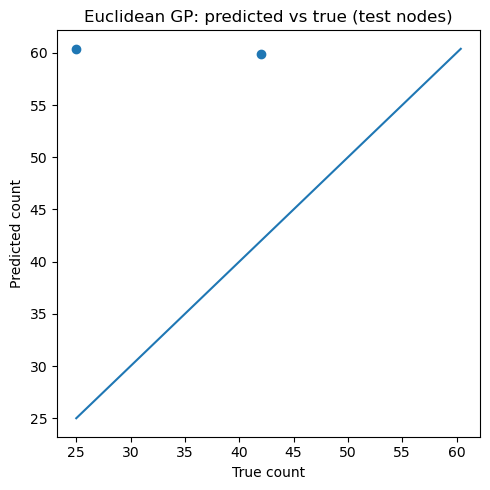

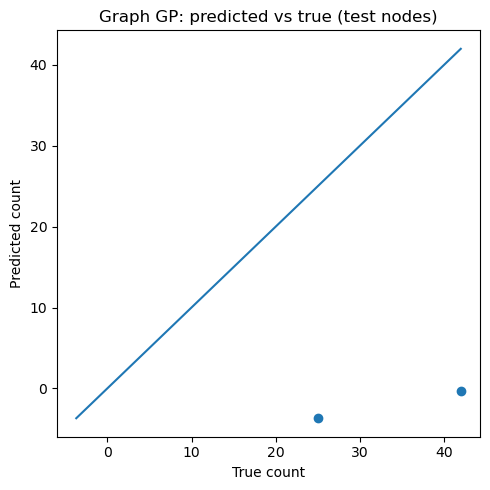

,counter_site,y_y,resid_euc,resid_graph
10,Schlieffenstraße,5.415567e+06,17.921026,-42.358228
13,Solitudeallee,5.414530e+06,35.390067,-28.698113


In [13]:
def scatter_pred_vs_true(y_true, y_pred, title):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred)
    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True count")
    plt.ylabel("Predicted count")
    plt.title(title)
    plt.tight_layout()
    plt.show()

scatter_pred_vs_true(y_test, pred_mean_euc, "Euclidean GP: predicted vs true (test nodes)")
scatter_pred_vs_true(y_test, pred_mean_graph, "Graph GP: predicted vs true (test nodes)")

test_plot = test_df.copy()
test_plot["resid_euc"] = pred_mean_euc - y_test
test_plot["resid_graph"] = pred_mean_graph - y_test

display(test_plot[["counter_site","y_y","resid_euc","resid_graph"]].head())



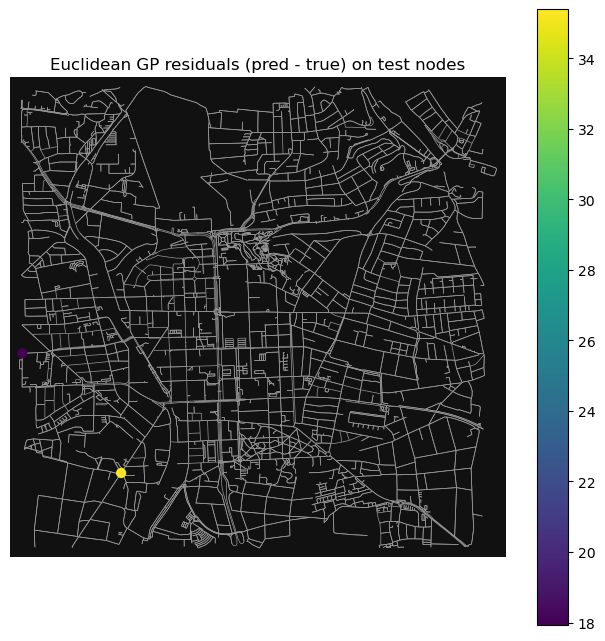

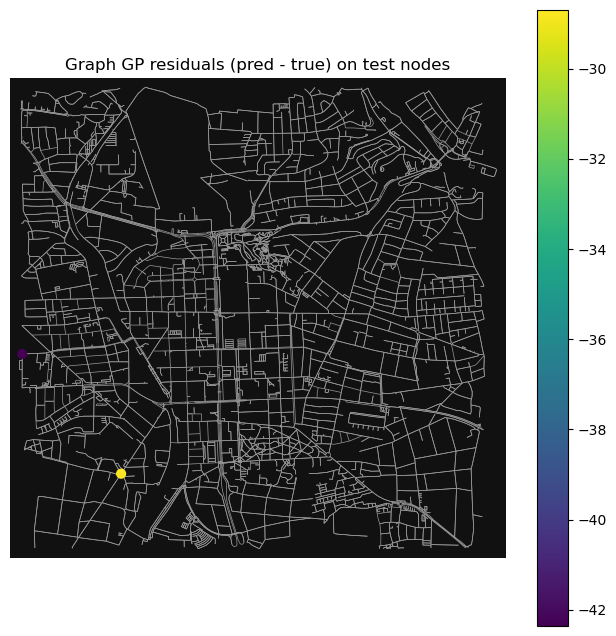

In [14]:
# Residual maps on the graph (test nodes only)
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)
sc = ax.scatter(test_plot["x"], test_plot["y_y"], c=test_plot["resid_euc"], s=40)
plt.colorbar(sc, ax=ax)
ax.set_title("Euclidean GP residuals (pred - true) on test nodes")
plt.show()

fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)
sc = ax.scatter(test_plot["x"], test_plot["y_y"], c=test_plot["resid_graph"], s=40)
plt.colorbar(sc, ax=ax)
ax.set_title("Graph GP residuals (pred - true) on test nodes")
plt.show()



## 7) Optional: full-field maps (all nodes)



In [15]:
# Euclidean GP predictions at all nodes
mean_all_euc, std_all_euc = gp_euc.predict(node_xy[["x","y"]].to_numpy(dtype=float), return_std=True)

# Graph GP predictions at all nodes
all_node_idx = np.array([node_to_idx[n] for n in node_xy["node_id"]], dtype=int)
Zall = Z[all_node_idx, :]
Kall_tr = Zall @ Ztr.T
mean_all_graph = Kall_tr @ alpha

Kall_diag = np.sum(Zall**2, axis=1)
vall = la.solve_triangular(L, Kall_tr.T, lower=True, check_finite=False)
var_all_graph = np.maximum(0.0, Kall_diag - np.sum(vall*vall, axis=0))
std_all_graph = np.sqrt(var_all_graph)

node_xy_plot = node_xy.copy()
node_xy_plot["mean_euc"] = mean_all_euc
node_xy_plot["std_euc"] = std_all_euc
node_xy_plot["mean_graph"] = mean_all_graph
node_xy_plot["std_graph"] = std_all_graph



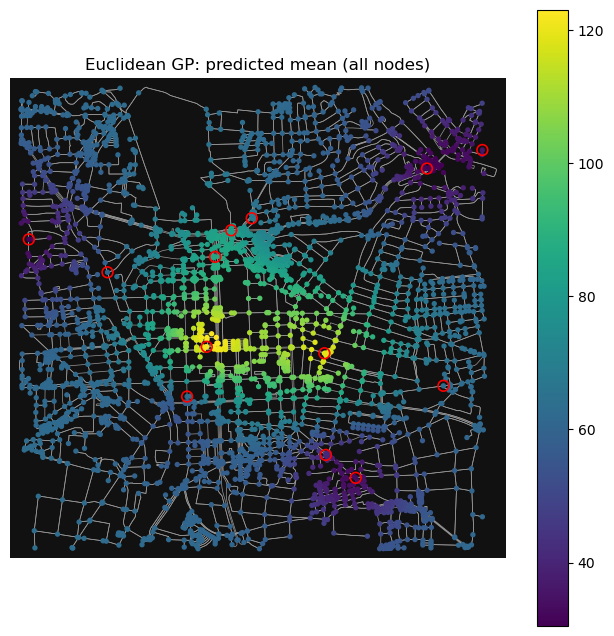

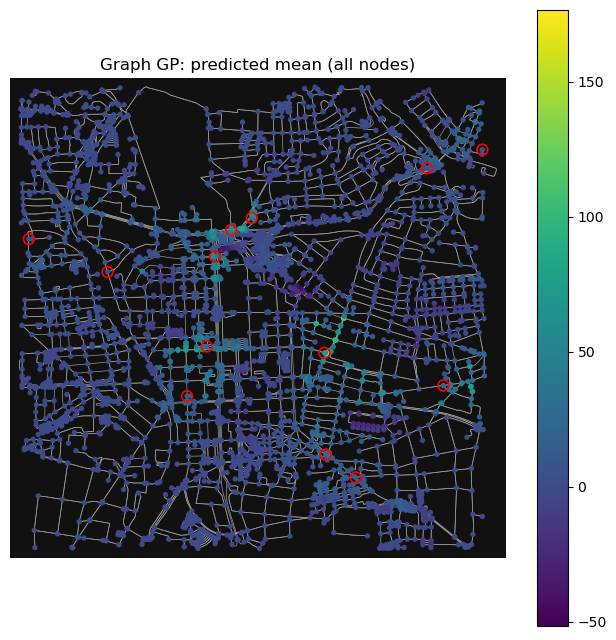

In [16]:
# Plot predicted mean (all nodes)
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)
sc = ax.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["mean_euc"], s=8)
ax.scatter(
    node_xy_plot.iloc[train_node_idx]["x"],
    node_xy_plot.iloc[train_node_idx]["y"],
    facecolors="none",
    edgecolors="red",
    s=60,
    linewidths=1.2,
    zorder=10
)
plt.colorbar(sc, ax=ax)
ax.set_title("Euclidean GP: predicted mean (all nodes)")
plt.show()

fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)
sc = ax.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["mean_graph"], s=8)
ax.scatter(
    node_xy_plot.iloc[train_node_idx]["x"],
    node_xy_plot.iloc[train_node_idx]["y"],
    facecolors="none",
    edgecolors="red",
    s=60,
    linewidths=1.2,
    zorder=10
)
plt.colorbar(sc, ax=ax)
ax.set_title("Graph GP: predicted mean (all nodes)")
plt.show()



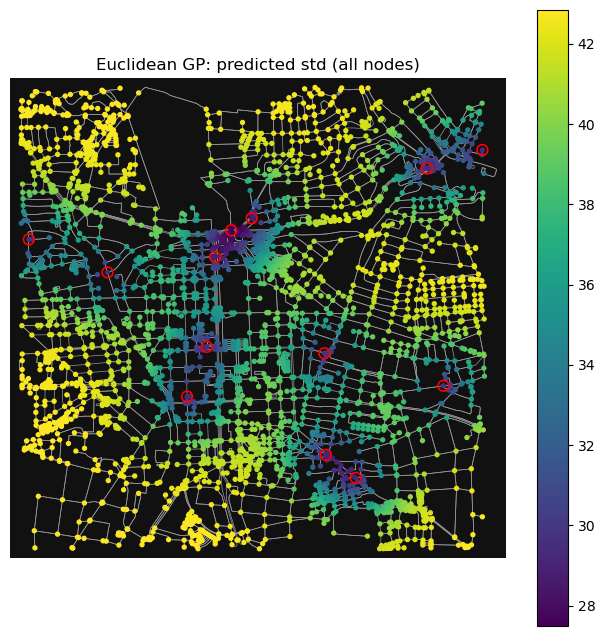

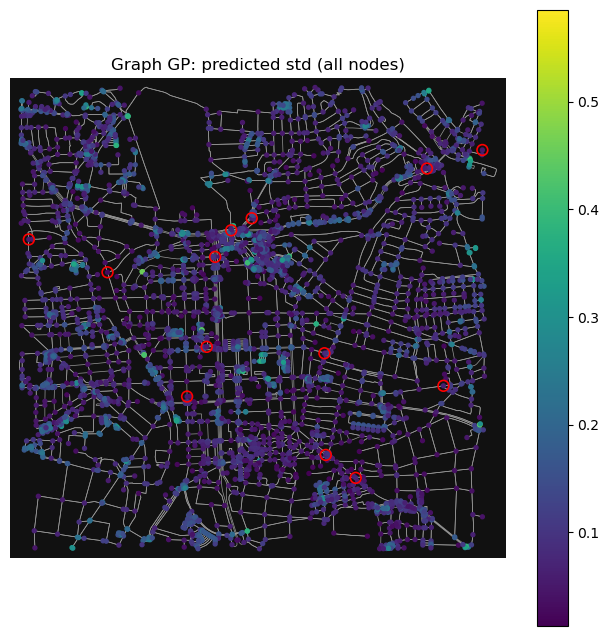

In [17]:
# Plot predicted uncertainty (all nodes)
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)
sc = ax.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["std_euc"], s=8)
ax.scatter(
    node_xy_plot.iloc[train_node_idx]["x"],
    node_xy_plot.iloc[train_node_idx]["y"],
    facecolors="none",
    edgecolors="red",
    s=60,
    linewidths=1.2,
    zorder=10
)
plt.colorbar(sc, ax=ax)
ax.set_title("Euclidean GP: predicted std (all nodes)")
plt.show()

fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)
sc = ax.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["std_graph"], s=8)
ax.scatter(
    node_xy_plot.iloc[train_node_idx]["x"],
    node_xy_plot.iloc[train_node_idx]["y"],
    facecolors="none",
    edgecolors="red",
    s=60,
    linewidths=1.2,
    zorder=10
)
plt.colorbar(sc, ax=ax)
ax.set_title("Graph GP: predicted std (all nodes)")
plt.show()

